In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from pyscf import gto, scf, ao2mo, cc

import importlib

import wavefunctions, hamiltonian, trajectory, qc

/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


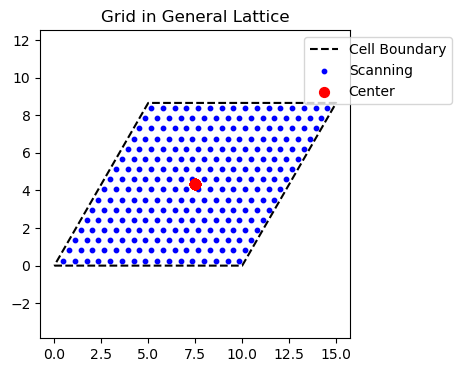

In [2]:
def makeTwoElectronGrid(gridPoints, dim, lattice):
    """
    Creates configurations for 2 electrons in a general lattice cell.
    - Electron 0: Fixed at center of the cell.
    - Electron 1: Scans grid midpoints (uniform in fractional coords).
    
    Args:
        gridPoints: Number of points per dimension.
        dim: 2 or 3
        lattice: (dim, dim) jnp.array, rows are lattice vectors.
    """
    # 1. Generate fractional coordinates (0 to 1)
    #    We shift by 0.5/gridPoints so points are in the middle of voxels
    u = jnp.linspace(0, 1, gridPoints, endpoint=False) + (1.0 / gridPoints / 2.0)
    
    # 2. Create meshgrid in fractional space
    grids_u = jnp.meshgrid(*([u] * dim), indexing='ij')
    
    # 3. Flatten to get fractional positions: (TotalPoints, dim)
    scan_u = jnp.stack(grids_u, axis=-1).reshape(-1, dim)
    
    # 4. Convert Fractional -> Cartesian
    #    r = u_1*a_1 + u_2*a_2 ...
    scan_pos = jnp.dot(scan_u, lattice)
    
    # 5. Fixed Position (Cell Center)
    #    Center is just the vector sum of lattice vectors / 2
    center_pos = 0.5 * jnp.sum(lattice, axis=0)
    fixed_pos = jnp.tile(center_pos, (scan_pos.shape[0], 1))
    
    # 6. Stack them
    rs = jnp.stack([fixed_pos, scan_pos], axis=1)
    
    return rs

# --- Visualization ---

gridPoints = 16
dim = 2

# Example: Tilted (Hexagonal-ish) Lattice
lattice = jnp.array([
    [10.0, 0.0],
    [5.0, 8.66]
])

rs = makeTwoElectronGrid(gridPoints, dim, lattice)

plt.figure(figsize=(4, 4))

# 1. Plot the lattice boundary manually
#    Corners: (0,0) -> a1 -> a1+a2 -> a2 -> (0,0)
origin = jnp.zeros(2)
a1 = lattice[0]
a2 = lattice[1]
box_x = [0, a1[0], a1[0]+a2[0], a2[0], 0]
box_y = [0, a1[1], a1[1]+a2[1], a2[1], 0]

plt.plot(box_x, box_y, 'k--', linewidth=1.5, label='Cell Boundary')

# 2. Plot electrons
plt.scatter(rs[:,1,0], rs[:,1,1], color='blue', s=10, label='Scanning')
plt.scatter(rs[:,0,0], rs[:,0,1], color='red', s=50, zorder=10, label='Center')

plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.title("Grid in General Lattice")
plt.show()

In [3]:
importlib.reload(wavefunctions)
importlib.reload(hamiltonian)

spins = (1,1)
dim = 3

gridPoints = 96
N = spins[0] + spins[1]

for r_ws in [1.0, 5.0, 10.0, 20.0, 110.0]:

    L = wavefunctions.computeL(N, r_ws, dim)
    
    lattice = L * jnp.eye(dim)
    lattice = L * jnp.eye(dim) + L / 3
    lattice = jnp.array([
        [ L/2.5  , L/20 , L/20],
        [ L/20 ,  L   , L/20],
        [ L/20 , L/20 ,  L  ]
    ])
    
    system = qc.ueg_qc(0, spins, dim=dim, e_cut_red=0.0, basis=lattice)
    #system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=5.0)
    k_points = system.get_k_points()
    n_kpts = k_points.shape[0]
    if n_kpts != 1:
        raise Exception("Too many k-points for some reason!")
    h1 = system.get_h1(k_points)
    eri_jax = system.get_eri_tensor_real(k_points)
    eri = np.asarray(eri_jax, dtype=np.double)
    
    mol = gto.M(verbose=0)
    mol.nelectron = system.n_particles
    mol.incore_anyway = True
    mol.energy_nuc = lambda *args: 0.0
    mol.verbose = 0
    
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n_kpts)
    mf._eri = ao2mo.restore(8, eri, n_kpts)
    mf.init_guess = "1e"
    escf = mf.kernel()
    
    kpoints = wavefunctions.genKpoints(N//2, lattice, dim)
    wavefunction = wavefunctions.LogSimpleSlaters(spins, dim, kpoints)
    localEnergy = hamiltonian.LocalEnergyUEG(wavefunction, lattice)

    rng = jax.random.PRNGKey(558)

    rng, rs_rng, init_rng = jax.random.split(rng, 3)
    rs = trajectory.wignerCrystal(spins, r_ws, L, 8, rs_rng, dim=dim)
    parameters = wavefunction.initBatch(init_rng, rs)
    rs = makeTwoElectronGrid(gridPoints, dim, lattice)

    wfVals = wavefunction.applyBatch(parameters, rs)
    energies = localEnergy.batch(parameters, rs)
    weights = jnp.exp(2.0 * wfVals)
    vmc_energy = jnp.average(energies, weights=weights)

    diff = vmc_energy - escf
    
    print(f"r_s: {r_ws}\tSCF: {escf:.6}\tVMC: {vmc_energy:.6}\tDiff: {diff}")

/mnt/c/Users/pravi/Documents/vmc/qc.py:344: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)
/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)


r_s: 1.0	SCF: -1.31125	VMC: -1.31204	Diff: -0.000788569450378418


/mnt/c/Users/pravi/Documents/vmc/qc.py:344: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)
/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)


r_s: 5.0	SCF: -0.26225	VMC: -0.262407	Diff: -0.0001577138900756836
r_s: 10.0	SCF: -0.131125	VMC: -0.131204	Diff: -7.88569450378418e-05
r_s: 20.0	SCF: -0.0655624	VMC: -0.0656019	Diff: -3.94284725189209e-05
r_s: 110.0	SCF: -0.0119204	VMC: -0.0119276	Diff: -7.1711838245391846e-06


In [4]:
importlib.reload(wavefunctions)
importlib.reload(hamiltonian)

spins = (1,1)
dim = 2

gridPoints = 1024
N = spins[0] + spins[1]

for r_ws in [1.0, 5.0, 10.0, 20.0, 110.0]:

    L = wavefunctions.computeL(N, r_ws, dim)
    
    lattice = L * jnp.eye(dim)
    lattice = L * jnp.eye(dim) + L / 3
    lattice = jnp.array([
        [ L/1.5 , L/20 ],
        [ L/20  , L    ]
    ])
    
    system = qc.ueg_qc(0, spins, dim=dim, e_cut_red=0.0, basis=lattice)
    #system = ueg_qc(r_ws, spins, dim=dim, e_cut_red=5.0)
    k_points = system.get_k_points()
    n_kpts = k_points.shape[0]
    if n_kpts != 1:
        raise Exception("Too many k-points for some reason!")
    h1 = system.get_h1(k_points)
    eri_jax = system.get_eri_tensor_real(k_points)
    eri = np.asarray(eri_jax, dtype=np.double)
    
    mol = gto.M(verbose=0)
    mol.nelectron = system.n_particles
    mol.incore_anyway = True
    mol.energy_nuc = lambda *args: 0.0
    mol.verbose = 0
    
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n_kpts)
    mf._eri = ao2mo.restore(8, eri, n_kpts)
    mf.init_guess = "1e"
    escf = mf.kernel()
    
    kpoints = wavefunctions.genKpoints(N//2, lattice, dim)
    wavefunction = wavefunctions.LogSimpleSlaters(spins, dim, kpoints)
    localEnergy = hamiltonian.LocalEnergyUEG2D(wavefunction, lattice)

    rng = jax.random.PRNGKey(558)

    rng, rs_rng, init_rng = jax.random.split(rng, 3)
    rs = trajectory.wignerCrystal(spins, r_ws, L, 8, rs_rng, dim=dim)
    parameters = wavefunction.initBatch(init_rng, rs)
    rs = makeTwoElectronGrid(gridPoints, dim, lattice)

    wfVals = wavefunction.applyBatch(parameters, rs)
    energies = localEnergy.batch(parameters, rs)
    weights = jnp.exp(2.0 * wfVals)
    vmc_energy = jnp.average(energies, weights=weights)

    diff = vmc_energy - escf
    
    print(f"r_s: {r_ws}\tSCF: {escf:.6}\tVMC: {vmc_energy:.6}\tDiff: {diff}")

/mnt/c/Users/pravi/Documents/vmc/qc.py:344: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  U = jnp.zeros((n_kpts, n_kpts), dtype=jnp.complex128)
/home/amress/miniforge3/envs/nqs/lib/python3.9/site-packages/pyscf/gto/mole.py:1293: UserWarning: Function mol.dumps drops attribute energy_nuc because it is not JSON-serializable
  warnings.warn(msg)


r_s: 1.0	SCF: -1.85902	VMC: -1.8599	Diff: -0.0008807182312011719
r_s: 5.0	SCF: -0.371804	VMC: -0.37198	Diff: -0.0001761019229888916
r_s: 10.0	SCF: -0.185902	VMC: -0.18599	Diff: -8.80509614944458e-05
r_s: 20.0	SCF: -0.0929511	VMC: -0.0929951	Diff: -4.40254807472229e-05
r_s: 110.0	SCF: -0.0169002	VMC: -0.0169082	Diff: -8.005648851394653e-06
